## Try to maximize the likelihood (compressed params)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import lya_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_15/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup LyaTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_sim.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=sim_cosmo)
else:
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.cosmo.cosmo_fid)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology for testing)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]]
else:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [9]:
# print truth in test simulation
like.get_simulation_linP_params(test_sim_label)

{'f_star': 0.9813909211842693,
 'g_star': 0.9677508863420937,
 'linP_kms': poly1d([-0.10814533, -2.29861294, 15.92231369]),
 'Delta2_star': 0.30364823417031134,
 'n_star': -2.2986129401746167,
 'alpha_star': -0.21629065209715273}

In [10]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
Delta2_star = 0.355
n_star = -2.301
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 979.8041889043435


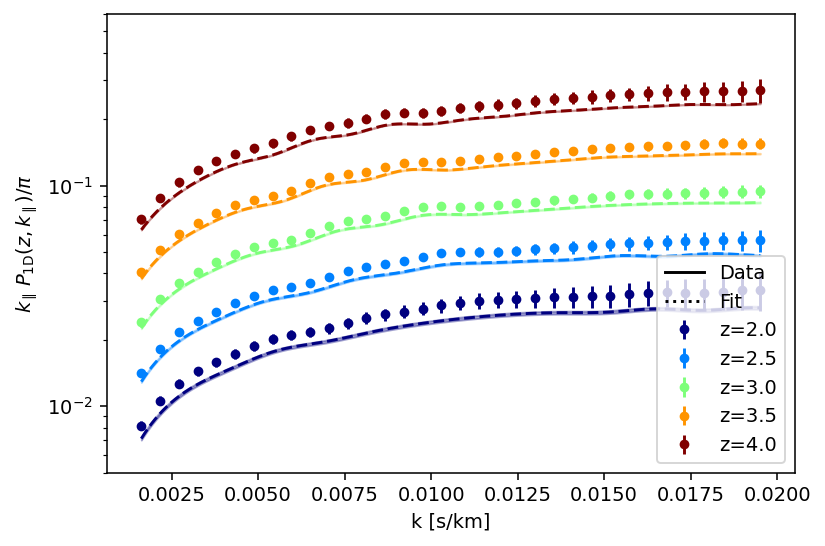

In [11]:
like.plot_p1d(plot_every_iz=2)

# Run minimiser

In [12]:
from scipy.optimize import minimize

In [13]:
def callbackF(xk):
    chi2=like.get_chi2(values=xk)
    print('chi2 =',chi2,'at x=',xk)
    for par in like.parameters_from_sampling_point(xk):
        print(par.info_str())

In [14]:
results=minimize(like.minus_log_prob, x0=theta,method = 'Nelder-Mead',
                 options={'disp':True,'maxiter':1000},callback=callbackF)

chi2 = 724.8371962129813 at x= [0.5   0.5   0.525 0.5   0.5   0.5  ]
Delta2_star = 0.355
n_star = -2.301
ln_tau_0 = 0.010000000000000009
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
chi2 = 596.5270173508572 at x= [0.51666667 0.45416667 0.51666667 0.51666667 0.4875     0.51666667]
Delta2_star = 0.3588333333333333
n_star = -2.305675
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2 = 596.5270173508572 at x= [0.51666667 0.45416667 0.51666667 0.51666667 0.4875     0.51666667]
Delta2_star = 0.3588333333333333
n_star = -2.305675
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2 = 411.759730962908 at x= [0.53333333 0.475      0.53333333 0.47083333 0.475      0.53333333]
Delta2_star = 0.36266666666666664
n_star = -2.30355
ln_tau_0 = 0.01333333333333328
ln_sigT_kms_0 = -0.011666666666666714
ln_gamma_0 = -0.00999

chi2 = 61.25595216469973 at x= [0.48262187 0.49446753 0.71854647 0.41457211 0.41815535 0.52663211]
Delta2_star = 0.35100302920639026
n_star = -2.3015643115064717
ln_tau_0 = 0.08741858837662697
ln_sigT_kms_0 = -0.03417115686875577
ln_gamma_0 = -0.032737859988874074
ln_kF_0 = 0.01065284366585395
chi2 = 55.34355620867271 at x= [0.51325007 0.50827064 0.7009373  0.38056367 0.42303341 0.52618748]
Delta2_star = 0.35804751506209
n_star = -2.300156394660654
ln_tau_0 = 0.08037492104363764
ln_sigT_kms_0 = -0.047774530696288314
ln_gamma_0 = -0.03078663641309931
ln_kF_0 = 0.010474993490575735
chi2 = 40.92897878550773 at x= [0.42536062 0.58560624 0.74959672 0.39204221 0.4601632  0.46504968]
Delta2_star = 0.33783294241042816
n_star = -2.2922681635256423
ln_tau_0 = 0.09983868856265515
ln_sigT_kms_0 = -0.043183115753280626
ln_gamma_0 = -0.015934720394774782
ln_kF_0 = -0.013980127997510305
chi2 = 40.92897878550773 at x= [0.42536062 0.58560624 0.74959672 0.39204221 0.4601632  0.46504968]
Delta2_star = 0.

chi2 = 8.801193405747352 at x= [0.30703292 0.64553422 0.75109171 0.43889721 0.45747238 0.4398536 ]
Delta2_star = 0.310617571104251
n_star = -2.2861555092871257
ln_tau_0 = 0.10043668469154493
ln_sigT_kms_0 = -0.02444111652951042
ln_gamma_0 = -0.01701104696852823
ln_kF_0 = -0.0240585602555225
chi2 = 7.75548050948379 at x= [0.28893003 0.64509319 0.75975549 0.45101437 0.44811325 0.43567892]
Delta2_star = 0.3064539079708273
n_star = -2.2862004948503305
ln_tau_0 = 0.10390219675048218
ln_sigT_kms_0 = -0.019594253667799016
ln_gamma_0 = -0.020754700844134222
ln_kF_0 = -0.025728433587773436
chi2 = 7.75548050948379 at x= [0.28893003 0.64509319 0.75975549 0.45101437 0.44811325 0.43567892]
Delta2_star = 0.3064539079708273
n_star = -2.2862004948503305
ln_tau_0 = 0.10390219675048218
ln_sigT_kms_0 = -0.019594253667799016
ln_gamma_0 = -0.020754700844134222
ln_kF_0 = -0.025728433587773436
chi2 = 7.75548050948379 at x= [0.28893003 0.64509319 0.75975549 0.45101437 0.44811325 0.43567892]
Delta2_star = 0.30

chi2 = 5.250547490534299 at x= [0.2195915  0.52176855 0.75002312 0.60810617 0.27668531 0.50226818]
Delta2_star = 0.29050604531342705
n_star = -2.298779608283756
ln_tau_0 = 0.1000092472509207
ln_sigT_kms_0 = 0.043242466631809584
ln_gamma_0 = -0.08932587416419513
ln_kF_0 = 0.0009072728283870679
chi2 = 5.6522265817444275 at x= [0.24880724 0.5195288  0.73762208 0.5962368  0.28225818 0.50079826]
Delta2_star = 0.2972256658515325
n_star = -2.299008062063146
ln_tau_0 = 0.0950488315334741
ln_sigT_kms_0 = 0.03849471860102183
ln_gamma_0 = -0.08709672742487173
ln_kF_0 = 0.00031930517863409946
chi2 = 5.551448140534745 at x= [0.23125386 0.52016514 0.74385337 0.59769994 0.28772226 0.50354058]
Delta2_star = 0.2931883882017345
n_star = -2.2989431558596576
ln_tau_0 = 0.09754134949820908
ln_sigT_kms_0 = 0.039079975932067745
ln_gamma_0 = -0.08491109583972332
ln_kF_0 = 0.0014162324149461225
chi2 = 5.551448140534745 at x= [0.23125386 0.52016514 0.74385337 0.59769994 0.28772226 0.50354058]
Delta2_star = 0.29

chi2 = 5.199729695305473 at x= [0.23476809 0.5263491  0.74531779 0.59643207 0.28872365 0.49443502]
Delta2_star = 0.29399666167245475
n_star = -2.2983123919339388
ln_tau_0 = 0.09812711502450117
ln_sigT_kms_0 = 0.038572829960628774
ln_gamma_0 = -0.08451054073738558
ln_kF_0 = -0.0022259919298519004
chi2 = 5.199729695305473 at x= [0.23476809 0.5263491  0.74531779 0.59643207 0.28872365 0.49443502]
Delta2_star = 0.29399666167245475
n_star = -2.2983123919339388
ln_tau_0 = 0.09812711502450117
ln_sigT_kms_0 = 0.038572829960628774
ln_gamma_0 = -0.08451054073738558
ln_kF_0 = -0.0022259919298519004
chi2 = 5.154297217893591 at x= [0.23397532 0.52818571 0.74620609 0.59637557 0.28994281 0.49279933]
Delta2_star = 0.29381432381673267
n_star = -2.2981250574414545
ln_tau_0 = 0.09848243548458935
ln_sigT_kms_0 = 0.0385502287068768
ln_gamma_0 = -0.0840228758942925
ln_kF_0 = -0.0028802684545063406
chi2 = 5.154297217893591 at x= [0.23397532 0.52818571 0.74620609 0.59637557 0.28994281 0.49279933]
Delta2_star =

chi2 = 4.985881275224212 at x= [0.23200292 0.5263159  0.7469234  0.59977752 0.28797751 0.49036552]
Delta2_star = 0.29336067108346914
n_star = -2.298315778245188
ln_tau_0 = 0.09876936102733175
ln_sigT_kms_0 = 0.03991100911141654
ln_gamma_0 = -0.08480899498528527
ln_kF_0 = -0.0038537921205460957
chi2 = 4.985881275224212 at x= [0.23200292 0.5263159  0.7469234  0.59977752 0.28797751 0.49036552]
Delta2_star = 0.29336067108346914
n_star = -2.298315778245188
ln_tau_0 = 0.09876936102733175
ln_sigT_kms_0 = 0.03991100911141654
ln_gamma_0 = -0.08480899498528527
ln_kF_0 = -0.0038537921205460957
chi2 = 4.985881275224212 at x= [0.23200292 0.5263159  0.7469234  0.59977752 0.28797751 0.49036552]
Delta2_star = 0.29336067108346914
n_star = -2.298315778245188
ln_tau_0 = 0.09876936102733175
ln_sigT_kms_0 = 0.03991100911141654
ln_gamma_0 = -0.08480899498528527
ln_kF_0 = -0.0038537921205460957
chi2 = 4.985881275224212 at x= [0.23200292 0.5263159  0.7469234  0.59977752 0.28797751 0.49036552]
Delta2_star = 0.

chi2 = 4.984428136990919 at x= [0.23149332 0.52132923 0.74697276 0.59938835 0.28599175 0.49241277]
Delta2_star = 0.2932434639295834
n_star = -2.2988244185884286
ln_tau_0 = 0.09878910349766945
ln_sigT_kms_0 = 0.039755338925590966
ln_gamma_0 = -0.08560330189236708
ln_kF_0 = -0.003034892681403084
chi2 = 4.984428136990919 at x= [0.23149332 0.52132923 0.74697276 0.59938835 0.28599175 0.49241277]
Delta2_star = 0.2932434639295834
n_star = -2.2988244185884286
ln_tau_0 = 0.09878910349766945
ln_sigT_kms_0 = 0.039755338925590966
ln_gamma_0 = -0.08560330189236708
ln_kF_0 = -0.003034892681403084
chi2 = 4.984428136990919 at x= [0.23149332 0.52132923 0.74697276 0.59938835 0.28599175 0.49241277]
Delta2_star = 0.2932434639295834
n_star = -2.2988244185884286
ln_tau_0 = 0.09878910349766945
ln_sigT_kms_0 = 0.039755338925590966
ln_gamma_0 = -0.08560330189236708
ln_kF_0 = -0.003034892681403084
chi2 = 5.022392534695365 at x= [0.23172352 0.52239082 0.74706746 0.59750263 0.28851511 0.49237626]
Delta2_star = 0.

chi2 = 4.993851308878703 at x= [0.22716574 0.51725946 0.75000404 0.5883393  0.29517131 0.49282722]
Delta2_star = 0.292248120206058
n_star = -2.299239534762434
ln_tau_0 = 0.10000161544057873
ln_sigT_kms_0 = 0.035335720666886866
ln_gamma_0 = -0.08193147547150895
ln_kF_0 = -0.00286911178090668
chi2 = 5.04303096222528 at x= [0.22651823 0.5140229  0.75090096 0.58254723 0.29874721 0.49411547]
Delta2_star = 0.2920991927002893
n_star = -2.2995696638893577
ln_tau_0 = 0.10036038588787982
ln_sigT_kms_0 = 0.03301889005062614
ln_gamma_0 = -0.08050111736937159
ln_kF_0 = -0.002353813674896482
chi2 = 5.049274880393881 at x= [0.22806423 0.51801684 0.75025305 0.58457527 0.29823532 0.49281034]
Delta2_star = 0.2924547736663253
n_star = -2.2991622825700464
ln_tau_0 = 0.10010121939125344
ln_sigT_kms_0 = 0.03383010972755959
ln_gamma_0 = -0.0807058723987527
ln_kF_0 = -0.00287586209752716
chi2 = 5.049274880393881 at x= [0.22806423 0.51801684 0.75025305 0.58457527 0.29823532 0.49281034]
Delta2_star = 0.29245477

chi2 = 4.987271115971867 at x= [0.22812378 0.51797808 0.7491923  0.58781144 0.29234846 0.49266134]
Delta2_star = 0.29246846920723935
n_star = -2.299166235657805
ln_tau_0 = 0.09967692184543397
ln_sigT_kms_0 = 0.03512457454294768
ln_gamma_0 = -0.08306061754692112
ln_kF_0 = -0.002935465112554686
chi2 = 4.987271115971867 at x= [0.22812378 0.51797808 0.7491923  0.58781144 0.29234846 0.49266134]
Delta2_star = 0.29246846920723935
n_star = -2.299166235657805
ln_tau_0 = 0.09967692184543397
ln_sigT_kms_0 = 0.03512457454294768
ln_gamma_0 = -0.08306061754692112
ln_kF_0 = -0.002935465112554686
chi2 = 4.987271115971867 at x= [0.22812378 0.51797808 0.7491923  0.58781144 0.29234846 0.49266134]
Delta2_star = 0.29246846920723935
n_star = -2.299166235657805
ln_tau_0 = 0.09967692184543397
ln_sigT_kms_0 = 0.03512457454294768
ln_gamma_0 = -0.08306061754692112
ln_kF_0 = -0.002935465112554686
chi2 = 4.987271115971867 at x= [0.22812378 0.51797808 0.7491923  0.58781144 0.29234846 0.49266134]
Delta2_star = 0.292

chi2 = 5.459311409971951 at x= [0.23062092 0.51406304 0.74812251 0.5066881  0.28426773 0.50109946]
Delta2_star = 0.29304281063197896
n_star = -2.2995655698873745
ln_tau_0 = 0.09924900264726855
ln_sigT_kms_0 = 0.002675241535555095
ln_gamma_0 = -0.08629290688626289
ln_kF_0 = 0.00043978285218065905
chi2 = 5.4364246995272225 at x= [0.22985583 0.50843339 0.74716422 0.49267028 0.27836184 0.50220788]
Delta2_star = 0.2928668399945701
n_star = -2.300139794684065
ln_tau_0 = 0.09886568658925698
ln_sigT_kms_0 = -0.0029318876757979118
ln_gamma_0 = -0.08865526486363384
ln_kF_0 = 0.0008831501713320034
chi2 = 5.4364246995272225 at x= [0.22985583 0.50843339 0.74716422 0.49267028 0.27836184 0.50220788]
Delta2_star = 0.2928668399945701
n_star = -2.300139794684065
ln_tau_0 = 0.09886568658925698
ln_sigT_kms_0 = -0.0029318876757979118
ln_gamma_0 = -0.08865526486363384
ln_kF_0 = 0.0008831501713320034
chi2 = 5.470082494157709 at x= [0.23047657 0.5231315  0.75023659 0.48565923 0.29372774 0.49465339]
Delta2_sta

chi2 = 4.3672929213271345 at x= [0.2097631  0.52312426 0.75691207 0.27505646 0.23048637 0.46938306]
Delta2_star = 0.2882455131830142
n_star = -2.2986413252839952
ln_tau_0 = 0.10276482991599745
ln_sigT_kms_0 = -0.08997741475525133
ln_gamma_0 = -0.1078054511346368
ln_kF_0 = -0.012246775342425631
chi2 = 4.3672929213271345 at x= [0.2097631  0.52312426 0.75691207 0.27505646 0.23048637 0.46938306]
Delta2_star = 0.2882455131830142
n_star = -2.2986413252839952
ln_tau_0 = 0.10276482991599745
ln_sigT_kms_0 = -0.08997741475525133
ln_gamma_0 = -0.1078054511346368
ln_kF_0 = -0.012246775342425631
chi2 = 4.432418443231625 at x= [0.21669748 0.53935851 0.75579317 0.2901041  0.24131084 0.46571573]
Delta2_star = 0.2898404195342323
n_star = -2.296985432333022
ln_tau_0 = 0.1023172671101415
ln_sigT_kms_0 = -0.08395835853549338
ln_gamma_0 = -0.10347566436160288
ln_kF_0 = -0.013713709042101396
chi2 = 4.657792199813009 at x= [0.21404228 0.52783849 0.7548353  0.27082132 0.23413321 0.47388154]
Delta2_star = 0.28

chi2 = 4.627414840225915 at x= [0.21619445 0.5302386  0.75543332 0.2725521  0.23804422 0.47264695]
Delta2_star = 0.2897247243895975
n_star = -2.297915662895083
ln_tau_0 = 0.10217332686863828
ln_sigT_kms_0 = -0.0909791592723759
ln_gamma_0 = -0.10478231074290903
ln_kF_0 = -0.01094121840036194
chi2 = 4.627414840225915 at x= [0.21619445 0.5302386  0.75543332 0.2725521  0.23804422 0.47264695]
Delta2_star = 0.2897247243895975
n_star = -2.297915662895083
ln_tau_0 = 0.10217332686863828
ln_sigT_kms_0 = -0.0909791592723759
ln_gamma_0 = -0.10478231074290903
ln_kF_0 = -0.01094121840036194
chi2 = 4.627414840225915 at x= [0.21619445 0.5302386  0.75543332 0.2725521  0.23804422 0.47264695]
Delta2_star = 0.2897247243895975
n_star = -2.297915662895083
ln_tau_0 = 0.10217332686863828
ln_sigT_kms_0 = -0.0909791592723759
ln_gamma_0 = -0.10478231074290903
ln_kF_0 = -0.01094121840036194
chi2 = 4.601179374613466 at x= [0.2174339  0.53205463 0.75462095 0.27581901 0.23612183 0.47240389]
Delta2_star = 0.290009796

chi2 = 4.581028150766374 at x= [0.21594122 0.5321283  0.75515664 0.27974372 0.23542143 0.47211754]
Delta2_star = 0.289666480436248
n_star = -2.297722912975784
ln_tau_0 = 0.10206265605907122
ln_sigT_kms_0 = -0.08810251393777553
ln_gamma_0 = -0.1058314284219528
ln_kF_0 = -0.01115298230409062
chi2 = 4.581887392604671 at x= [0.21577363 0.53153833 0.75535747 0.2754109  0.23500595 0.47215432]
Delta2_star = 0.2896279349533125
n_star = -2.2977830906737458
ln_tau_0 = 0.10214298906793462
ln_sigT_kms_0 = -0.08983564083115812
ln_gamma_0 = -0.10599761898382948
ln_kF_0 = -0.011138270617348123
chi2 = 4.581887392604671 at x= [0.21577363 0.53153833 0.75535747 0.2754109  0.23500595 0.47215432]
Delta2_star = 0.2896279349533125
n_star = -2.2977830906737458
ln_tau_0 = 0.10214298906793462
ln_sigT_kms_0 = -0.08983564083115812
ln_gamma_0 = -0.10599761898382948
ln_kF_0 = -0.011138270617348123
chi2 = 4.583422373463648 at x= [0.21549604 0.53077531 0.75540987 0.2788178  0.23556254 0.47247126]
Delta2_star = 0.2895

chi2 = 4.5883977563908225 at x= [0.21586985 0.53158272 0.75523774 0.28064578 0.23539339 0.47255485]
Delta2_star = 0.28965006481802597
n_star = -2.297778562529481
ln_tau_0 = 0.10209509605933514
ln_sigT_kms_0 = -0.08774168659977595
ln_gamma_0 = -0.10584264537266591
ln_kF_0 = -0.01097806097272258
chi2 = 4.5905589209869415 at x= [0.21579907 0.53145902 0.7552764  0.28041833 0.23541236 0.47261315]
Delta2_star = 0.28963378597635114
n_star = -2.2977911803159055
ln_tau_0 = 0.1021105591981904
ln_sigT_kms_0 = -0.08783266826009184
ln_gamma_0 = -0.10583505521928233
ln_kF_0 = -0.010954740896398835
chi2 = 4.5905589209869415 at x= [0.21579907 0.53145902 0.7552764  0.28041833 0.23541236 0.47261315]
Delta2_star = 0.28963378597635114
n_star = -2.2977911803159055
ln_tau_0 = 0.1021105591981904
ln_sigT_kms_0 = -0.08783266826009184
ln_gamma_0 = -0.10583505521928233
ln_kF_0 = -0.010954740896398835
chi2 = 4.58737525166107 at x= [0.21577125 0.53144643 0.75527426 0.28048547 0.23528465 0.47257899]
Delta2_star = 0

chi2 = 4.5885412122089075 at x= [0.21581075 0.53144719 0.75526214 0.28035866 0.23533377 0.47259079]
Delta2_star = 0.28963647168374707
n_star = -2.2977923862830334
ln_tau_0 = 0.10210485420109577
ln_sigT_kms_0 = -0.08785653754639791
ln_gamma_0 = -0.10586649274202616
ln_kF_0 = -0.010963682699901084
Optimization terminated successfully.
         Current function value: 35.902431
         Iterations: 400
         Function evaluations: 628


### Compare to truth

In [15]:
print('maximum posterior =',-results.fun)
callbackF(results.x)

maximum posterior = -35.902430588964656
chi2 = 4.5885412122089075 at x= [0.21581075 0.53144719 0.75526214 0.28035866 0.23533377 0.47259079]
Delta2_star = 0.28963647168374707
n_star = -2.2977923862830334
ln_tau_0 = 0.10210485420109577
ln_sigT_kms_0 = -0.08785653754639791
ln_gamma_0 = -0.10586649274202616
ln_kF_0 = -0.010963682699901084


In [16]:
like.get_simulation_linP_params(test_sim_label)

{'f_star': 0.9813909211842693,
 'g_star': 0.9677508863420937,
 'linP_kms': poly1d([-0.10814533, -2.29861294, 15.92231369]),
 'Delta2_star': 0.30364823417031134,
 'n_star': -2.2986129401746167,
 'alpha_star': -0.21629065209715273}

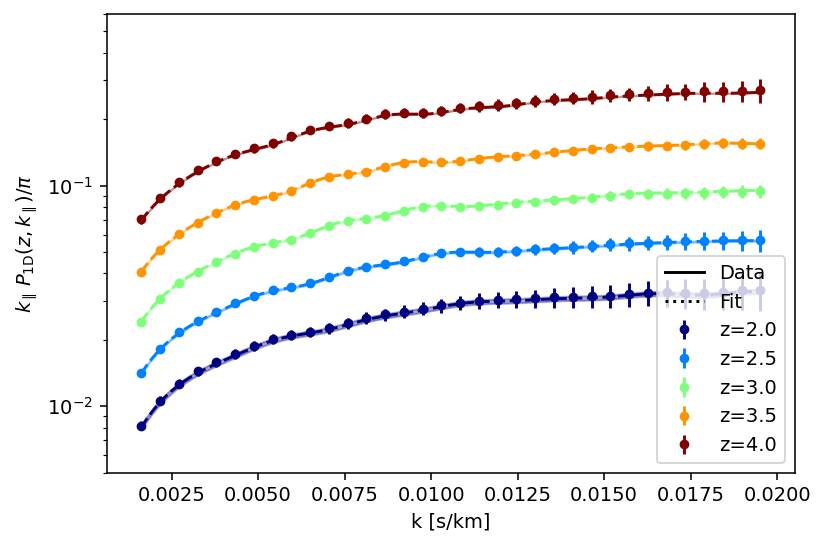

In [17]:
like.plot_p1d(plot_every_iz=2,values=results.x)